In [1]:
import numpy as np
import pandas as pd
import sqlite3
import json

import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim 
import folium

## Load `places` db with radar scanning
fetch_id.sh used nearby search to find all parks within a bounding box.

In [85]:
# Read sqlite query results into a pandas DataFrame
# con = sqlite3.connect("center_city_r2k_places_20210316_120135.db")
con = sqlite3.connect("pine_grove_cape_may_r2k_places_20210316_120447.db")
df = pd.read_sql_query("SELECT id, name from places", con)

print(df.shape)

# Verify that result of SQL query is stored in the dataframe
print(df.head())


(8200, 2)
                            id                                         name
0  ChIJAWkAqNL1t4kRlm4slspOSXo                            Quiet Waters Park
1  ChIJy3QzWM31t4kRNuSzKdQUh5w                 Reading and Butterfly Garden
2  ChIJcyqDA9P1t4kRzHEeyOEbdRM                              Paddle or Pedal
3  ChIJkYjq18f1t4kREPcPHKKpF1M                         Quiet Waters Retreat
4  ChIJN3yTAZv1t4kRyyO9WoLA4-0  Hillsmere Shores Community Beach & Pavilion


In [86]:
cur = con.cursor()
row = cur.execute("SELECT COUNT(DISTINCT id) FROM places")
list(row)

[(6445,)]

### Add new features from data in .db (e.g. rating)

In [87]:
def extract_feature(value, name, default=None):
    content = json.loads(value)
    return content.get(name, default)

df_content = pd.read_sql_query("SELECT data from places", con)
con.close()

df_content.shape

(8200, 1)

In [95]:
content = json.loads(df_content['data'][0])
content.keys()

dict_keys(['business_status', 'geometry', 'icon', 'name', 'opening_hours', 'photos', 'place_id', 'plus_code', 'rating', 'reference', 'scope', 'types', 'user_ratings_total', 'vicinity'])

In [96]:
price_level = df_content.data.apply(extract_feature, args=('price_level',), default=None)
price_level.describe()

count    8.000000
mean     1.750000
std      0.707107
min      0.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      2.000000
Name: data, dtype: float64

In [97]:
def extract_location(value, default=None):
    content = json.loads(value)
    geo = content.get('geometry', default)
    if geo:
        location = geo.get('location', default)
        if location:
            coords = (location['lat'], location['lng'])
    else:
        coords = default
    return coords

In [98]:
df['rating'] = df_content.data.apply(extract_feature, args=('rating',), default=None)

df['user_ratings_total'] = df_content.data.apply(extract_feature, args=('user_ratings_total',), default=None)

df['geometry'] = df_content.data.apply(extract_location, default=None)

In [129]:
df['lat'] = df['geometry'].apply(lambda x: x[0])
df['lng'] = df['geometry'].apply(lambda x: x[1])

In [103]:
df.head()

,id,name,rating,user_ratings_total,geometry,lat,lng
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,4.7,1314.0,"(38.93766979999999, -76.5008994)",38.937670,-76.500899
1,ChIJy3QzWM31t4kRNuSzKdQUh5w,Reading and Butterfly Garden,4.4,17.0,"(38.9370975, -76.50178919999999)",38.937098,-76.501789
2,ChIJcyqDA9P1t4kRzHEeyOEbdRM,Paddle or Pedal,4.6,78.0,"(38.93632719999999, -76.5096645)",38.936327,-76.509664
3,ChIJkYjq18f1t4kREPcPHKKpF1M,Quiet Waters Retreat,NaN,NaN,"(38.9292445, -76.50452729999999)",38.929245,-76.504527
4,ChIJN3yTAZv1t4kRyyO9WoLA4-0,Hillsmere Shores Community Beach & Pavilion,NaN,NaN,"(38.9270241, -76.4941111)",38.927024,-76.494111


### select distinct parks and those with ratings (o.w. the park might be too obsolete)

In [130]:
df_clean = df.dropna(axis=0)
df_clean.shape

(5017, 7)

In [131]:
df_clean_distinct = df_clean.drop_duplicates(subset=['id'])

In [132]:
df_clean_distinct.shape

(4076, 7)

In [133]:
df_clean_distinct

,id,name,rating,user_ratings_total,geometry,lat,lng
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,4.7,1314.0,"(38.93766979999999, -76.5008994)",38.937670,-76.500899
1,ChIJy3QzWM31t4kRNuSzKdQUh5w,Reading and Butterfly Garden,4.4,17.0,"(38.9370975, -76.50178919999999)",38.937098,-76.501789
2,ChIJcyqDA9P1t4kRzHEeyOEbdRM,Paddle or Pedal,4.6,78.0,"(38.93632719999999, -76.5096645)",38.936327,-76.509664
5,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,5.0,4.0,"(38.927212, -76.4941501)",38.927212,-76.494150
6,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,4.7,175.0,"(38.93020219999999, -76.50834069999999)",38.930202,-76.508341
...,...,...,...,...,...,...,...
8187,ChIJ8VFM3PLjw4kRWHo927zq9ZM,Carson Road Woods,4.5,31.0,"(40.3303328, -74.7126849)",40.330333,-74.712685
8188,ChIJfTYtWB_kw4kR2kqMn-JJ1V0,Woodfield Reservation,4.6,39.0,"(40.36827220000001, -74.69591849999999)",40.368272,-74.695918
8194,ChIJFS1EP-nvw4kR_pUJY-Js6R4,Sourland Mountain Preserve,4.7,1015.0,"(40.4746508, -74.7027559)",40.474651,-74.702756
8196,ChIJfaCteILuw4kR41kLsSrnjdc,River Road,2.9,7.0,"(40.50016890000001, -74.7216359)",40.500169,-74.721636


### save the clean ids
for a second round of popularity queries

In [73]:
# distinct_conn = sqlite3.connect("cleaned_pine_grove_cape_may_r2k_places_20210316_120447.db")
# df_clean_distinct.drop(columns=['geometry']).to_sql('places', distinct_conn)
# distinct_conn.close()

1293


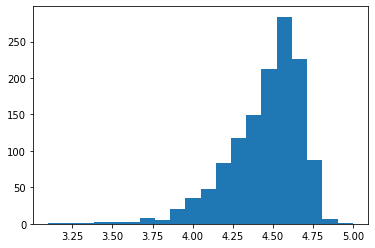

In [184]:
min_rating_n = 50
plt.hist(df_clean_distinct[df_clean_distinct['user_ratings_total']>min_rating_n]['rating'], 20); 
print(df_clean_distinct[df_clean_distinct['user_ratings_total']>min_rating_n].shape[0])

## Load initial detail/popularity query results - to identify the ones with `popular times`
This includes place id, name, address, and whether this place contains popular times information. 

In [113]:
# con = sqlite3.connect('pine_grove_cape_may_r2k_popularity_20210316_143722.db')#earlier testing .db
con = sqlite3.connect('pine_grove_cape_may_r2k_popularity_20210316_144723.db')
cursor = con.cursor()

print('total number of entries: ' + str(list(cursor.execute("SELECT COUNT(*) FROM popularity"))))

pop_df = pd.read_sql_query("SELECT id, name, address, has_popular_times, curr_popularity from popularity WHERE has_popular_times > 0", con)
pop_df # entries with 'popular times' are 1656

total number of entries: [(4076,)]


,id,name,address,has_popular_times,curr_popularity
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",1,49
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,"101 W Bay View Dr, Annapolis, MD 21403, USA",1,-1
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ...",1,-1
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",1,49
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,"273 Hilltop Ln, Annapolis, MD 21403, USA",1,-1
...,...,...,...,...,...
1651,ChIJfVzC4e1EwYkR7CX7hHL8w-I,Township Park,"Columbus, NJ 08022, USA",1,-1
1652,ChIJN_dm4uVbwYkRmsPTaQhpCsI,Abbott Marshlands,"Bordentown, NJ 08505, USA",1,-1
1653,ChIJd9ol6rtbwYkR6v7KxxO7Z6k,Scenic Overlook,"Hamilton Township, NJ 08611, USA",1,-1
1654,ChIJ8VFM3PLjw4kRWHo927zq9ZM,Carson Road Woods,"Carson Rd, Princeton, NJ 08540, USA",1,-1


In [114]:
# get the "blob" with all query details
pop_df_detail = pd.read_sql_query("SELECT details FROM popularity WHERE has_popular_times > 0", con)
pop_df_detail.head()
con.close()

In [107]:
example_detail = json.loads(pop_df_detail['details'][0])

print(example_detail.keys())
# included 5 reviews

example_detail['reviews'][0]

dict_keys(['address_components', 'adr_address', 'business_status', 'formatted_address', 'formatted_phone_number', 'geometry', 'icon', 'international_phone_number', 'name', 'opening_hours', 'photos', 'place_id', 'plus_code', 'rating', 'reference', 'reviews', 'types', 'url', 'user_ratings_total', 'utc_offset', 'vicinity', 'website'])


{'author_name': 'C P',
 'author_url': 'https://www.google.com/maps/contrib/117657423554503070588/reviews',
 'language': 'en',
 'profile_photo_url': 'https://lh3.googleusercontent.com/a-/AOh14Ghgw0869KhD2KmVlwN-6t-vaNbc_LebRYUfwy1spw=s128-c0x00000000-cc-rp-mo-ba4',
 'rating': 5,
 'relative_time_description': '3 weeks ago',
 'text': "Lots to do here throughout the year! Definitely worth the annual pass if you'll be visiting often. You can also park in the nearby commercial lot and walk into Quiet Waters. Paved and unpaved trails. Pond with turtles and big fish. Playground. Pavilions. Dog park. Dog beach. Free concerts in the summer. Ice rink in the winter. And much more! I've been a visitor since 2005 and now the whole family (including the fur babies) enjoys outings here on a regular basis.",
 'time': 1613536710}

In [108]:
# opening hours
example_detail['opening_hours']['periods']

[{'close': {'day': 0, 'time': '2000'}, 'open': {'day': 0, 'time': '0700'}},
 {'close': {'day': 1, 'time': '2000'}, 'open': {'day': 1, 'time': '0700'}},
 {'close': {'day': 2, 'time': '2000'}, 'open': {'day': 2, 'time': '0700'}},
 {'close': {'day': 3, 'time': '2000'}, 'open': {'day': 3, 'time': '0700'}},
 {'close': {'day': 4, 'time': '2000'}, 'open': {'day': 4, 'time': '0700'}},
 {'close': {'day': 5, 'time': '2000'}, 'open': {'day': 5, 'time': '0700'}},
 {'close': {'day': 6, 'time': '2000'}, 'open': {'day': 6, 'time': '0700'}}]

In [109]:
# find the ones with curr_popularity returned (191 out of 1656 that has 'popular times')
pop_df[pop_df['curr_popularity']>-1]

,id,name,address,has_popular_times,curr_popularity
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",1,49
5,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",1,49
8,ChIJz5r9fYr2t4kRLfV-5MwIeH4,Truxtun Park,"273 Hilltop Ln, Annapolis, MD 21403, USA",1,30
9,ChIJP75lm3n2t4kRVKf9vxXsiIc,K&B True Value,"912 Forest Dr, Annapolis, MD 21403, USA",1,25
18,ChIJVbM6qUj2t4kRx4LbudL2R8E,Annapolis City Dock,"Dock St, Annapolis, MD 21401, USA",1,24
...,...,...,...,...,...
3980,ChIJc8WiT9TawIkR91cBEoe2dS4,Lake Lenape Park East,"753 Park Rd, Mays Landing, NJ 08330, USA",1,61
3990,ChIJU1Pfj1tGwYkR7rTv1Y6LYNw,Historic Smithville Park,"803 Smithville Rd, Eastampton Township, NJ 080...",1,167
4022,ChIJk3GxnYZYwYkROwdd1tiQvBA,Colonial Lake Park,"100 Bridge Dr, Lawrence Township, NJ 08648, USA",1,5
4026,ChIJ-4ReFgLjw4kRAm3BSq_dEh8,Village Park,"100 Maidenhead Lane, Lawrenceville, NJ 08648, USA",1,59


In [251]:
pop_df[pop_df['has_popular_times']>-1]

,id,name,address,curr_popularity,has_popular_times
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",49,1
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,"101 W Bay View Dr, Annapolis, MD 21403, USA",-1,1
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ...",-1,1
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",49,1
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,"273 Hilltop Ln, Annapolis, MD 21403, USA",-1,1
...,...,...,...,...,...
1651,ChIJfVzC4e1EwYkR7CX7hHL8w-I,Township Park,"Columbus, NJ 08022, USA",-1,1
1652,ChIJN_dm4uVbwYkRmsPTaQhpCsI,Abbott Marshlands,"Bordentown, NJ 08505, USA",-1,1
1653,ChIJd9ol6rtbwYkR6v7KxxO7Z6k,Scenic Overlook,"Hamilton Township, NJ 08611, USA",-1,1
1654,ChIJ8VFM3PLjw4kRWHo927zq9ZM,Carson Road Woods,"Carson Rd, Princeton, NJ 08540, USA",-1,1


In [115]:
def extract_postal_code(value, default=None):
    content = json.loads(value)
    postal_code = default
    if content['address_components']:
        postal_code = [content['address_components'][i]['short_name'] for i in range(len(content['address_components'])) 
         if content['address_components'][i]['types'][0]=='postal_code'][0]

    return postal_code


In [116]:
pop_df['postal code'] = pop_df_detail['details'].apply(extract_postal_code)

In [117]:
pop_df

,id,name,address,has_popular_times,curr_popularity,postal code
0,ChIJAWkAqNL1t4kRlm4slspOSXo,Quiet Waters Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",1,49,21403
1,ChIJzcow6Xb1t4kRQVE7s1AWWr8,Hillsmere Shores Community Beach,"101 W Bay View Dr, Annapolis, MD 21403, USA",1,-1,21403
2,ChIJ_bk5K1z1t4kRQNverIUOVko,Quiet Waters Dog Beach,"1701-1799 Quiet Waters Park Rd, Annapolis, MD ...",1,-1,21403
3,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,Quiet Waters Dog Park,"600 Quiet Waters Park Rd, Annapolis, MD 21403,...",1,49,21403
4,ChIJQWcsgIn2t4kRCL0Ub363FyI,Pip Moyer Recreation Center (Annapolis Recreat...,"273 Hilltop Ln, Annapolis, MD 21403, USA",1,-1,21403
...,...,...,...,...,...,...
1651,ChIJfVzC4e1EwYkR7CX7hHL8w-I,Township Park,"Columbus, NJ 08022, USA",1,-1,08022
1652,ChIJN_dm4uVbwYkRmsPTaQhpCsI,Abbott Marshlands,"Bordentown, NJ 08505, USA",1,-1,08505
1653,ChIJd9ol6rtbwYkR6v7KxxO7Z6k,Scenic Overlook,"Hamilton Township, NJ 08611, USA",1,-1,08611
1654,ChIJ8VFM3PLjw4kRWHo927zq9ZM,Carson Road Woods,"Carson Rd, Princeton, NJ 08540, USA",1,-1,08540


### save the task_list db
This list includes distinct ids of parks within the bounding box that includes 'popular times' (may not return live curr_popularity though).

In [253]:
# task_conn = sqlite3.connect("selected_pine_grove_cape_may_r2k_places_20210316_144723.db")
# pop_df.to_sql('task_list', task_conn)
# task_conn.close()

In [257]:
com_df = df_clean_distinct.merge(pop_df, how='inner', on='id')

In [259]:
com_df['user_ratings_total'].describe()

count     1656.000000
mean       235.761473
std        933.216700
min          1.000000
25%         28.000000
50%         70.500000
75%        181.250000
max      20481.000000
Name: user_ratings_total, dtype: float64

## Examine saved data scrapped every half hour: `curr_popularity` table

In [123]:
# curr_popularity
conn = sqlite3.connect("data/pine_grove_cape_may_popularity_half_hour.db")
pop_df = pd.read_sql_query("SELECT id, request_id, rating_n, timestamp, curr_popularity FROM curr_popularity", conn)
conn.close()

In [124]:
pop_df_curr = pop_df[pop_df['curr_popularity']>0]

In [134]:
pop_curr_with_feature = pop_df_curr.merge(df_clean_distinct, how='inner', on='id')
print(np.unique(pop_curr_with_feature['name']).shape)

(141,)


In [135]:
# 'curr_popularity' was extracted by search based on (name, address), 
#  its returned 'id' does not necessarily match with 'request_id' (used to find name & address)
pop_curr_with_feature[pop_curr_with_feature['id'] != pop_curr_with_feature['request_id']]

,id,request_id,rating_n,timestamp,curr_popularity,name,rating,user_ratings_total,geometry,lat,lng
1,ChIJAWkAqNL1t4kRlm4slspOSXo,ChIJ_-2cQEX1t4kRoiCrmNMbrQ8,1314,1615952611064,22,Quiet Waters Park,4.7,1314.0,"(38.93766979999999, -76.5008994)",38.937670,-76.500899
98,ChIJW9RvZomnx4kRPYy2EaXc1JQ,ChIJbZXWWc2nx4kRN-IM5xQowro,2076,1615952754365,50,Lums Pond State Park,4.6,2076.0,"(39.5603194, -75.7190612)",39.560319,-75.719061
99,ChIJW9RvZomnx4kRPYy2EaXc1JQ,ChIJbZXWWc2nx4kRN-IM5xQowro,2076,1615954564835,48,Lums Pond State Park,4.6,2076.0,"(39.5603194, -75.7190612)",39.560319,-75.719061
100,ChIJW9RvZomnx4kRPYy2EaXc1JQ,ChIJbZXWWc2nx4kRN-IM5xQowro,2076,1615956357528,48,Lums Pond State Park,4.6,2076.0,"(39.5603194, -75.7190612)",39.560319,-75.719061
101,ChIJW9RvZomnx4kRPYy2EaXc1JQ,ChIJbZXWWc2nx4kRN-IM5xQowro,2076,1615958154769,32,Lums Pond State Park,4.6,2076.0,"(39.5603194, -75.7190612)",39.560319,-75.719061
141,ChIJRUiJE3npxokRl7srK2qYPzk,ChIJIzbURnrpxokRRiyyITZghOQ,856,1615952863419,63,Rose Tree Park,4.6,856.0,"(39.9426024, -75.3934836)",39.942602,-75.393484


### Visualize the parks that contain `curr_popularity`

In [136]:
geolocator = Nominatim(user_agent="pa_explorer")

address = 'Philadelphia, PA'
location = geolocator.geocode(address)
latitude_pa = location.latitude
longitude_pa = location.longitude

# create map of Toronto using latitude and longitude values

map_pa = folium.Map(location=[latitude_pa, longitude_pa], zoom_start=7.5)

# add markers to map
for lat, lng, park in zip(pop_curr_with_feature['lat'], pop_curr_with_feature['lng'], pop_curr_with_feature['name']):
    if ~np.isnan(lat):
        label = "{}".format(park)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng], radius=5, popup=label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, 
            parse_html=False).add_to(map_pa)  
    else:
        print('Missing: {}.'.format(park))
    
map_pa

In [138]:
# show the entries with the same id (at multiple time point), to inspect google live updating frequency
pop_df_half_hour[pop_df_half_hour['id']==pop_df_half_hour.iloc[4]['id']]

,id,request_id,rating_n,timestamp,curr_popularity
4,ChIJz5r9fYr2t4kRLfV-5MwIeH4,ChIJz5r9fYr2t4kRLfV-5MwIeH4,351,1615952612182,74
1660,ChIJz5r9fYr2t4kRLfV-5MwIeH4,ChIJz5r9fYr2t4kRLfV-5MwIeH4,351,1615954412483,29
3317,ChIJz5r9fYr2t4kRLfV-5MwIeH4,ChIJz5r9fYr2t4kRLfV-5MwIeH4,351,1615956212425,29
4972,ChIJz5r9fYr2t4kRLfV-5MwIeH4,ChIJz5r9fYr2t4kRLfV-5MwIeH4,351,1615958012226,-1


# of parks with curr_popularity136


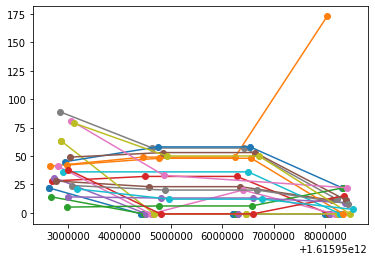

In [141]:
# find the ones with 'curr_popularity'
id_with_curr_popularity = pop_df_half_hour.iloc[[i for i,x in enumerate(pop_df_half_hour.iloc[:1656]['curr_popularity']>0) if x]]
print('# of parks with curr_popularity' + str(id_with_curr_popularity.shape[0]))

# for each of these parks, draw curr_popularity changes as a func of timestamp (sampled a few places)
for iexample in range(0, id_with_curr_popularity.shape[0], 7):
    iloc_ind = id_with_curr_popularity.index[iexample]
    plt.plot(pop_df_half_hour[pop_df_half_hour['id']==pop_df_half_hour.iloc[iloc_ind]['id']]['timestamp'].tolist(),
             pop_df_half_hour[pop_df_half_hour['id']==pop_df_half_hour.iloc[iloc_ind]['id']]['curr_popularity'].tolist(), '-o')